In [2]:
import deepchem as dc
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers   # a ver2 szintaktikához
from tensorflow.keras.utils import plot_model    # a modell vizualizációjához

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
import pandas as pd

### Adatsor betöltése a deepchem könyvtár segítségével

In [4]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter='scaffold', transformers=['normalization'])

In [5]:
train_dataset, valid_dataset, test_dataset = datasets

In [5]:
len(train_dataset.X)

1210

In [17]:
len(valid_dataset.X)

151

In [18]:
len(test_dataset.X)

152

### Mély neurális háló modell építése TensorFlow-ban

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])

In [8]:
model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam(0.001))

In [9]:
history = model.fit(train_dataset.X, train_dataset.y, epochs=50, validation_data=(valid_dataset.X, valid_dataset.y))

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.6949 - val_loss: 0.3535
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2858 - val_loss: 0.2387
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1765 - val_loss: 0.3523
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1468 - val_loss: 0.3245
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1271 - val_loss: 0.2985
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0974 - val_loss: 0.2817
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0946 - val_loss: 0.2822
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0761 - val_loss: 0.3540
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0882 - val_loss: 0.2513
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0875 - val_loss: 0.2637
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0824 - val_loss: 0.2821
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,0.043880,0.262888,45
46,0.046381,0.272479,46
47,0.039961,0.287602,47
48,0.042758,0.294208,48
49,0.042997,0.253430,49


In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()

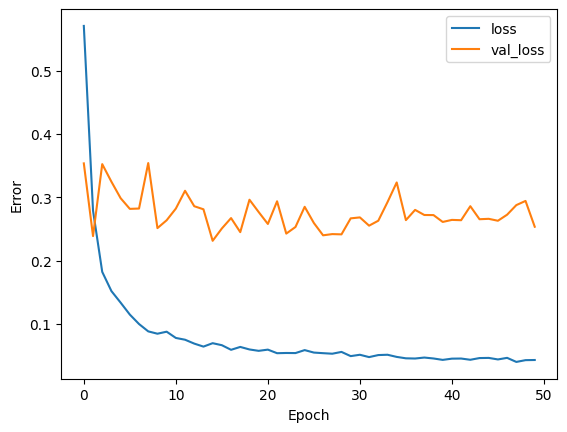

In [13]:
plot_loss(history)

In [14]:
model.evaluate(test_dataset.X, test_dataset.y)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8137 


0.8385609984397888

In [21]:
nn_predict_test = model.predict(test_dataset.X)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [22]:
nn_predict_train = model.predict(train_dataset.X)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Text(0, 0.5, 'Predictions')

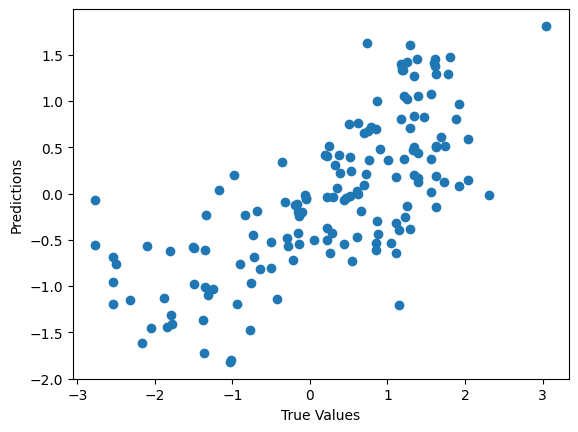

In [23]:
plt.scatter(test_dataset.y, nn_predict_test)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
MAE_train = mean_absolute_error(train_dataset.y, nn_predict_train)
MAE_test = mean_absolute_error(test_dataset.y, nn_predict_test)
print([MAE_train, MAE_test])

[0.11922297414167998, 0.7070247023217662]


In [25]:
MSE_train = mean_squared_error(train_dataset.y, nn_predict_train)
MSE_test = mean_squared_error(test_dataset.y, nn_predict_test)
print([MSE_train, MSE_test])

[0.033017804439556195, 0.8385610147300849]


In [26]:
r2_score(train_dataset.y, nn_predict_train)

0.9669821955604438

In [27]:
r2_score(test_dataset.y, nn_predict_test)

0.46339897912313033

### Az előző modell továbbfejlesztése L1 és L2 regularizációval

In [6]:
from tensorflow.keras import regularizers

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1(l1=0.00001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1(0.00001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])

In [43]:
model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam(0.001))

In [44]:
history = model.fit(train_dataset.X, train_dataset.y, epochs=50, validation_data=(valid_dataset.X, valid_dataset.y))

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.9713 - val_loss: 0.4336
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.4876 - val_loss: 0.4729
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.3964 - val_loss: 0.5318
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.3620 - val_loss: 0.4423
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.3384 - val_loss: 0.5149
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3196 - val_loss: 0.4544
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3126 - val_loss: 0.4773
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.2976 - val_loss: 0.4732
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.2852 - val_loss: 0.4659
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.2732 - val_loss: 0.5129
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.2666 - val_loss: 0.4363
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.2

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,0.205671,0.423124,45
46,0.196756,0.498435,46
47,0.199534,0.387233,47
48,0.196032,0.437200,48
49,0.193546,0.383408,49


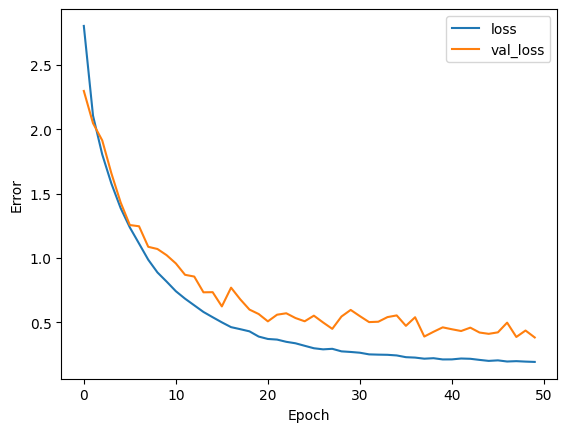

In [37]:
plot_loss(history)

### Hiperparaméter hangolás

In [7]:
import keras_tuner as kt

In [57]:
def model_builder(hp):
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_l1 = hp.Int('units_l1', min_value=32, max_value=512, step=32)
  hp_units_l2 = hp.Int('units_l2', min_value=32, max_value=512, step=32)

  model.add(tf.keras.layers.Dense(units=hp_units_l1, activation=hp.Choice("activation", ["relu", "tanh"]), kernel_regularizer=regularizers.L1(l1=hp.Choice("l1", values=[0.00001, 0.0001, 0.001]))))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=hp_units_l2, activation=hp.Choice("activation", ["relu", "tanh"]), kernel_regularizer=regularizers.L1(l1=hp.Choice("l1", values=[0.00001, 0.0001, 0.001]))))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='MeanSquaredError')

  return model

In [72]:
directory = r'C:\Users\User\Desktop\mesterséges intelligencia\szakdolgozat\Molecular_property_prediction\my_dir'

tuner = kt.RandomSearch(hypermodel=model_builder,max_trials=10, objective='val_loss', directory=directory, project_name='bace_regression')

In [73]:
tuner.search(train_dataset.X, train_dataset.y, epochs=50, validation_data=(valid_dataset.X, valid_dataset.y))

FailedPreconditionError: C:\Users\User\Desktop\mesterséges intelligencia\szakdolgozat\Molecular_property_prediction\my_dir\bace_regression is not a directory

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.get('units_l1'))
print(best_hp.get('units_l2'))
print(best_hp.get('learning_rate'))
print(best_hp.get('activation'))
print(best_hp.get('l1'))

### Modell építése a hangolt paraméterekkel

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(192, activation='tanh', kernel_regularizer=regularizers.L1(l1=0.00001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(224, activation='tanh', kernel_regularizer=regularizers.L1(0.00001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1)
])

In [9]:
model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam(0.001))

In [10]:
history = model.fit(train_dataset.X, train_dataset.y, epochs=50, validation_data=(valid_dataset.X, valid_dataset.y))

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.7910 - val_loss: 0.5252
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4730 - val_loss: 0.3893
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4465 - val_loss: 0.3747
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3765 - val_loss: 0.5422
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3406 - val_loss: 0.4235
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2953 - val_loss: 0.4566
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2983 - val_loss: 0.4346
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3108 - val_loss: 0.3866
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2664 - val_loss: 0.4872
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2836 - val_loss: 0.4991
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.2604 - val_loss: 0.6512
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,0.180779,0.648841,45
46,0.173461,0.589245,46
47,0.173485,0.561014,47
48,0.163578,0.582311,48
49,0.168891,0.569772,49


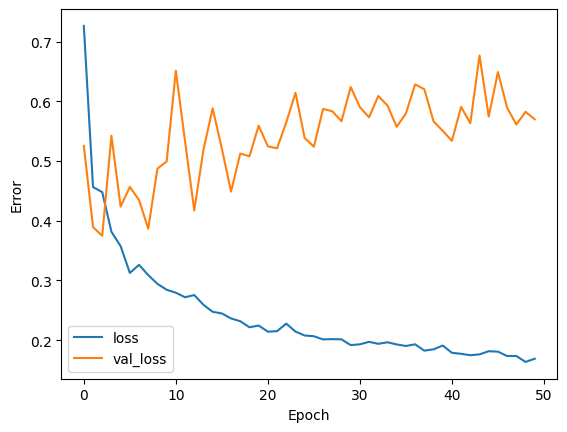

In [14]:
plot_loss(history)